# Surplux Solar Energy Analysis

## Import Package

In [2]:
import os
import math
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
SEED = 5397
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

## Helper Functions

Before we write the code for adjusting the models, lets define a few helper functions.

In [1]:
# Processing of data provided by the organizer 
def data_preprocessing(data):
    data['Date'] = pd.to_datetime(data['Date'])
    # 1 kwh = 3.6 MJ
    # 1 MJ to kwh = 0.27778 kwh
    data['Irradiance'] = data['Irradiance'] / 3.6
    data['Irradiance_m'] = data['Irradiance_m'] / 1000
    # Capacity Factor compare the power generation efficiency between plants of different scale.  
    data['CapacityFactor'] = data['Generation']/data['Capacity']
    # Array Ratio compares the energy collected through the system to the total system load by dividing energy in by energy-out. 
    data['ArrayRatio'] = data['CapacityFactor']/data['Irradiance']
    data['ArrayRatio_m'] = data['CapacityFactor']/data['Irradiance_m']
    return data

## Const & Inputs

Here are all of the parameters to change for the run.

In [6]:
# Top level data directory. Here we assume the format of the directory conforms to the ImageFolder structure
path = "."

## Data Description


| 欄位名稱     | 欄位說明                                             |
| ------------ | ---------------------------------------------------- |
| ID           | 資料編號                                             |
| Date         | 資料日期                                             |
| Temp         | 當日平均氣溫(°C)\[2\]                                |
| Temp_m       | 模溫計：模板溫度(°C)\[1\]                            |
| Irradiance   | 日射量(MJ/m²)\[2\]                                   |
| Irradiance_m | 日照計：日射量(Wh/m²)\[1\]                           |
| Generation   | 預測目標 - 發電量(kWh)                               |
| Capacity     | 裝置容量(kWp)                                        |
| Lat          | 緯度                                                 |
| Lon          | 經度                                                 |
| Angle        | 面向角度(0 為正南方，正值為偏向西方，負值為偏向東方) |
| Module       | 模組型號\[3\]                                        |


|                 | MM60-6RT-300 | SEC-6M-60A-295 | AUO PM060MW3 320W | AUO PM060MW3 325W |
| --------------- | ------------ | -------------- | ----------------- | ----------------- |
| 峰值輸出(Pmax)   | 300W           | 295W              | 320W              | 325W |
| 峰值電壓(Vmp)    | 32.61          | 31.6              | 33.48             | 33.66 |
| 峰值電流(Imp)    | 9.2            | 9.34              | 9.56              | 9.66 |
| 開路電壓(Voc)    | 38.97          | 39.4              | 40.9              | 41.1 |
| 短路電流(Isc)    | 9.68           | 9.85              | 10.24             | 10.35 |
| 模組效能(%)      | 18.44%         | 17.74%            | 19.2%             | 19.5% |

## Data Observation

- 觀察到 Temp_m 的缺值較多，是否僅發生在特定模組？ -> 只有 AUO 型號的模組有 Temp_m 屬性
- 觀察到 Irradiance 與 Temp 有約 20 筆缺值，觀察缺值發生的時間點？ -> 缺值通常連續發生，用線性補值效果可能不好
- 觀察到 Irradiance 與 Irradiance_m 平均值差距大，是否為離群值的影響？ -> 有 2 個案場的 Irradiance_m 直接用 Irradiance 補值
- 觀察到 Array Ratio 的平均值為 0.84 -> 符合普遍標準

In [9]:
train = pd.read_csv(os.path.join(path, 'data/train.csv'))
train = data_preprocessing(train)
train[['Temp', 'Temp_m', 'Irradiance', 'Irradiance_m', 'Generation', 'Capacity', 'CapacityFactor', 'ArrayRatio', 'ArrayRatio_m']].describe()

,Temp,Temp_m,Irradiance,Irradiance_m,Generation,Capacity,CapacityFactor,ArrayRatio,ArrayRatio_m
count,3569.000000,2126.000000,3560.000000,3584.000000,3584.000000,3584.000000,3584.000000,3560.000000,3584.000000
mean,25.722808,42.596990,4.796601,123.770042,1339.483817,350.535039,3.887639,0.848853,inf
std,5.341206,10.953377,1.894333,160.183435,796.698529,144.498892,1.538227,0.716940,NaN
min,6.900000,11.800000,0.036111,0.000000,17.000000,99.200000,0.077572,0.016551,0.000423
25%,22.000000,34.000000,3.658333,5.367000,575.000000,246.400000,2.992530,0.755726,0.018646
50%,28.200000,42.500000,5.213889,66.689500,1268.000000,352.000000,4.293808,0.816619,0.053874
75%,30.000000,51.700000,6.247917,171.738500,1957.000000,498.560000,5.039212,0.886738,0.773430
max,32.500000,68.500000,8.005556,1026.617000,6752.000000,499.800000,21.443089,30.141287,inf


## Analysis: Group
評估訓練模型的時候，資料的分組策略

In [19]:
def group_by_location(df):
    return df.groupby(['Lat', 'Lon']) \
        .agg({'Generation': 'size', 'ArrayRatio': 'mean', 'CapacityFactor': 'mean'}) \
        .rename(columns={'Generation': 'Count'}) \
        .reset_index() \
        .sort_values(by=['Lat', 'Lon'], ascending=False, ignore_index=True)
        
def group_by_lon(df):
    return df.groupby(['Lon']) \
        .agg({'Generation': 'size', 'ArrayRatio': 'mean', 'CapacityFactor': 'mean'}) \
        .rename(columns={'Generation': 'Count'}) \
        .reset_index() \
        .sort_values(by=['Lon'], ascending=False, ignore_index=True)
        
def group_by_lat(df):
    return df.groupby(['Lat']) \
        .agg({'Generation': 'size', 'ArrayRatio': 'mean', 'CapacityFactor': 'mean'}) \
        .rename(columns={'Generation': 'Count'}) \
        .reset_index() \
        .sort_values(by=['Lat'], ascending=False, ignore_index=True)
        
def group_by_module_capacity_location(df):
    return df.groupby(['Module', 'Capacity', 'Lat', 'Lon']) \
        .agg({'Generation': 'size', 'ArrayRatio': 'mean', 'CapacityFactor': 'mean'}) \
        .rename(columns={'Generation': 'Count'}) \
        .reset_index() \
        .sort_values(by=['Lat', 'Lon'], ascending=False, ignore_index=True)

### View Counts of Module
總共有 4 種模組型號，但由於相同模組可能被用在不同城市，可能無法以模組為單位訓練模型或規則

In [12]:
train.groupby(['Module']).size().reset_index(name='Counts')

,Module,Counts
0,AUO PM060MW3 320W,2106
1,AUO PM060MW3 325W,20
2,MM60-6RT-300,1142
3,SEC-6M-60A-295,316


### View Counts of Module and Location
基於發電機模組及案場經緯度進行分組，這個分類方法應該是最小單位  

第 7 個及第 8 個項目雖然模組型號不同，但設在相同地點，除以裝置容量正規化以後，應該可以放在一起訓練

In [13]:
train_counts_module_capacity_location = group_by_module_capacity_location(train)
train_counts_module_capacity_location[['Module', 'Lat', 'Lon', 'Capacity', 'CapacityFactor', 'ArrayRatio', 'Count']]

,Module,Lat,Lon,Capacity,CapacityFactor,ArrayRatio,Count
0,MM60-6RT-300,25.110,121.26,438.30,3.235256,0.861298,319
1,MM60-6RT-300,25.110,121.26,499.80,3.596847,0.912526,507
2,MM60-6RT-300,25.030,121.08,498.60,3.599382,0.766580,316
3,SEC-6M-60A-295,24.980,121.03,283.20,3.805748,0.820143,316
4,AUO PM060MW3 320W,24.107,120.44,246.40,4.022131,0.862380,395
5,AUO PM060MW3 320W,24.107,120.44,492.80,4.021890,0.861075,393
6,AUO PM060MW3 320W,24.090,120.52,278.40,3.921482,0.774278,158
7,AUO PM060MW3 320W,24.080,120.52,267.52,3.892630,0.762706,160
8,AUO PM060MW3 325W,24.080,120.52,343.20,3.779866,0.878274,20
9,AUO PM060MW3 320W,24.080,120.50,99.20,4.087650,0.881372,392


基於案場經緯度進行分組

由於 AUO PM060MW3 325W 的資料過少，故嘗試以案場經緯度進行分組，嘗試群組增加資料量。

In [21]:
train_counts_lat = group_by_lat(train)
train_counts_lat

,Lat,Count,ArrayRatio,CapacityFactor
0,25.110,826,0.892745,3.457201
1,25.030,316,0.766580,3.599382
2,24.980,316,0.820143,3.805748
3,24.107,788,0.861729,4.022011
4,24.090,158,0.774278,3.921482
5,24.080,572,0.847954,4.022337
6,24.070,314,0.850236,4.331238
7,24.060,132,0.872469,4.506479
8,24.040,162,0.838070,4.278086


In [20]:
train_counts_lon = group_by_lon(train)
train_counts_lon

,Lon,Count,ArrayRatio,CapacityFactor
0,121.26,826,0.892745,3.457201
1,121.08,316,0.766580,3.599382
2,121.03,316,0.820143,3.805748
3,120.52,500,0.795404,4.022124
4,120.50,392,0.881372,4.087650
5,120.48,160,0.856662,4.380133
6,120.47,286,0.856903,4.384765
7,120.44,788,0.861729,4.022011


## Analysis: Missing Value
觀察缺值的發生位置，評估屬性能不能使用

### Temp_m
僅 AUO 型號的模組有 Temp_m 屬性

In [127]:
train.groupby(['Module', 'Lat', 'Lon', 'Capacity']).count().reset_index()[['Module', 'Lat', 'Lon', 'Temp', 'Temp_m']]

,Module,Lat,Lon,Temp,Temp_m
0,AUO PM060MW3 320W,24.040,120.52,162,162
1,AUO PM060MW3 320W,24.060,120.47,132,132
2,AUO PM060MW3 320W,24.070,120.47,154,154
3,AUO PM060MW3 320W,24.070,120.48,160,160
4,AUO PM060MW3 320W,24.080,120.50,392,392
5,AUO PM060MW3 320W,24.080,120.52,160,160
6,AUO PM060MW3 320W,24.090,120.52,158,158
7,AUO PM060MW3 320W,24.107,120.44,395,395
8,AUO PM060MW3 320W,24.107,120.44,393,393
9,AUO PM060MW3 325W,24.080,120.52,20,20


### Irradiance & Temp
- Irradiance：(25.110, 121.26) 組合在 2021-02-12 ~ 2021-02-17 連續缺值 6 天 
- Temp：(25.110, 121.26) 組合在 2021-10-19 ~ 2021-10-25 連續缺值 7 天 
- 由於缺值連續發生，使用線性補值的效果可能不好

In [14]:
train[train['Irradiance'].isna()][['Module','Lat', 'Lon', 'Date', 'Generation', 'Irradiance']]

,Module,Lat,Lon,Date,Generation,Irradiance
80,MM60-6RT-300,25.110,121.26,2020-08-28,2213,NaN
81,MM60-6RT-300,25.110,121.26,2020-08-29,2272,NaN
182,AUO PM060MW3 320W,24.107,120.44,2020-10-13,1184,NaN
183,AUO PM060MW3 320W,24.107,120.44,2020-10-13,2320,NaN
184,AUO PM060MW3 320W,24.080,120.50,2020-10-13,464,NaN
306,AUO PM060MW3 320W,24.080,120.50,2020-11-13,152,NaN
307,AUO PM060MW3 320W,24.107,120.44,2020-11-13,759,NaN
308,AUO PM060MW3 320W,24.107,120.44,2020-11-13,382,NaN
393,MM60-6RT-300,25.110,121.26,2020-12-05,732,NaN
397,MM60-6RT-300,25.110,121.26,2020-12-06,505,NaN


### Irradiance & Irradiance_m
- 前 4 個案場 Irradiance 與 Irradiance_m 的值幾乎相同，比例與其他案場落差甚大，使得 Irradiance_m 的參考價值降低
- 所有案場的 Irradiance 與 Generation 曲線相符，較 Irradiance_m 更適合用來預測發電量
- 部分案場在夏季的轉換能力低落，可以嘗試加入年月因子
- 部分案場的輻射或發電量有極端值，要處理

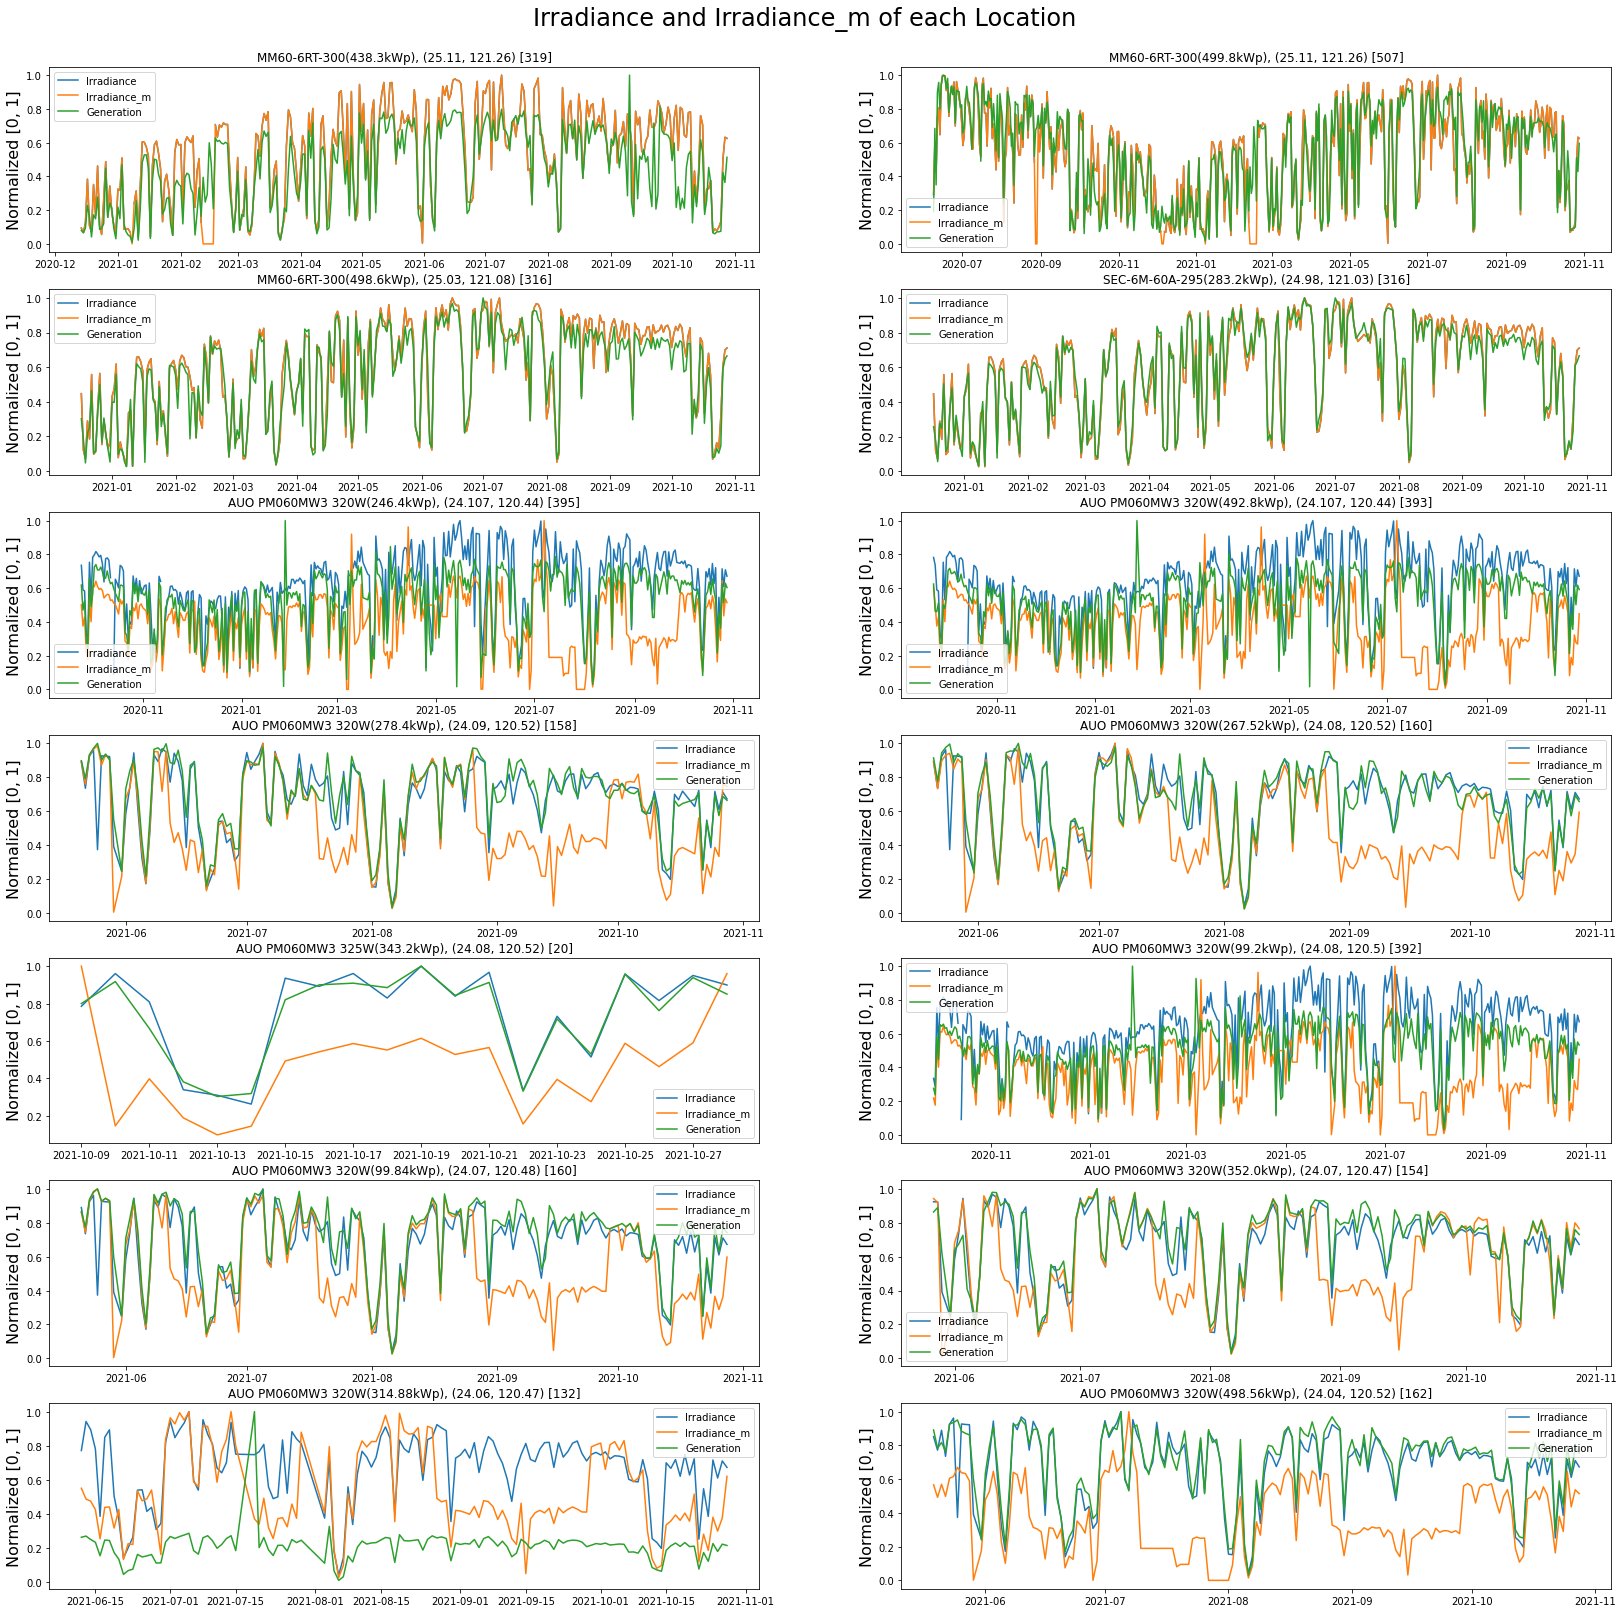

In [75]:
# drow Irradiance and Irradiance_m of each location
plt.figure(figsize=(28, 28))
plt.suptitle('Irradiance and Irradiance_m of each Location', fontsize=24, y=0.91)
for i, row in train_counts_module_capacity_location.iterrows():
    idf = train[train['Lat'].eq(row['Lat']) & train['Lon'].eq(row['Lon']) & train['Module'].eq(row['Module']) & train['Capacity'].eq(row['Capacity'])]
    plt.subplot(math.ceil(len(train_counts_module_capacity_location)/2), 2, i+1)
    plt.title(f"{row['Module']}({row['Capacity']}kWp), ({row['Lat']}, {row['Lon']}) [{len(idf)}]")
    # plt.plot(idf['Date'], idf['Irradiance'], label='Irradiance')
    # plt.plot(idf['Date'], idf['Irradiance_m'], label='Irradiance_m')
    plt.plot(idf['Date'], idf['Irradiance']/idf['Irradiance'].max(), label='Irradiance')
    plt.plot(idf['Date'], idf['Irradiance_m']/idf['Irradiance_m'].max(), label='Irradiance_m')
    plt.plot(idf['Date'], idf['Generation']/idf['Generation'].max(), label='Generation')
    # plt.ylabel('kWh/m²', fontsize=16)
    plt.ylabel('Normalized [0, 1]', fontsize=16)
    plt.legend() 


## Analysis: Outlier
觀察異常值的發生位置，評估如何處理

### Find and Define Outlier
人工觀察異常值發生的日期，建立異常日期清單

In [20]:
outliers = [
    {
        'irradiance': [],
        'generation': ['2021-09-10', '2021-09-14', '2021-09-21', '2021-09-23', '2021-10-03', '2021-10-04', '2021-10-05', '2021-10-06', '2021-10-07']
    },
    {
        'irradiance': [],
        'generation': []
    },
    {
        'irradiance': [],
        'generation': []
    },
    {
        'irradiance': [],
        'generation': []
    },
    {
        'irradiance': ['2020-10-14'],
        'generation': ['2021-01-27', '2021-01-28', '2021-05-14']
    },
    {
        'irradiance': ['2020-10-14'],
        'generation': ['2021-01-27', '2021-05-14']
    },
    {
        'irradiance': ['2021-05-25'],
        'generation': []
    },
    {
        'irradiance': ['2021-05-25'],
        'generation': []
    },
    {
        'irradiance': [],
        'generation': []
    },
    {
        'irradiance': ['2020-10-14'],
        'generation': ['2021-01-27', '2021-03-07']
    },
    {
        'irradiance': ['2021-05-25'],
        'generation': []
    },
    {
        'irradiance': [],
        'generation': []
    },
    {
        'irradiance': ['2021-08-04'],
        'generation': ['2021-07-19']
    },
    {
        'irradiance': ['2021-05-25'],
        'generation': []
    },
]

In [48]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=math.ceil(len(train_counts_module_capacity_location)/2), cols=2)
for i, row in train_counts_module_capacity_location.iterrows():
    idf = train[train['Lat'].eq(row['Lat']) & train['Lon'].eq(row['Lon']) & train['Module'].eq(row['Module']) & train['Capacity'].eq(row['Capacity'])]
    fig.add_trace(go.Scatter(x=idf['Date'], y=idf['Irradiance']/idf['Irradiance'].max(), name='Irradiance', line = dict(color='royalblue')), row=i//2+1, col=i%2+1)
    fig.add_trace(go.Scatter(x=idf['Date'], y=idf['Generation']/idf['Generation'].max(), name='Generation', line = dict(color='green')), row=i//2+1, col=i%2+1)
    fig.update_xaxes(title_text=f"{row['Module']}({row['Capacity']}kWp), ({row['Lat']}, {row['Lon']}) [{len(idf)}]", row=i//2+1, col=i%2+1)
fig.update_layout(height=1600, width=1600, title_text="Irradiance of each Location")

### View Outlier
在資料折線圖上面標註異常值，確認所有異常值都被鎖定

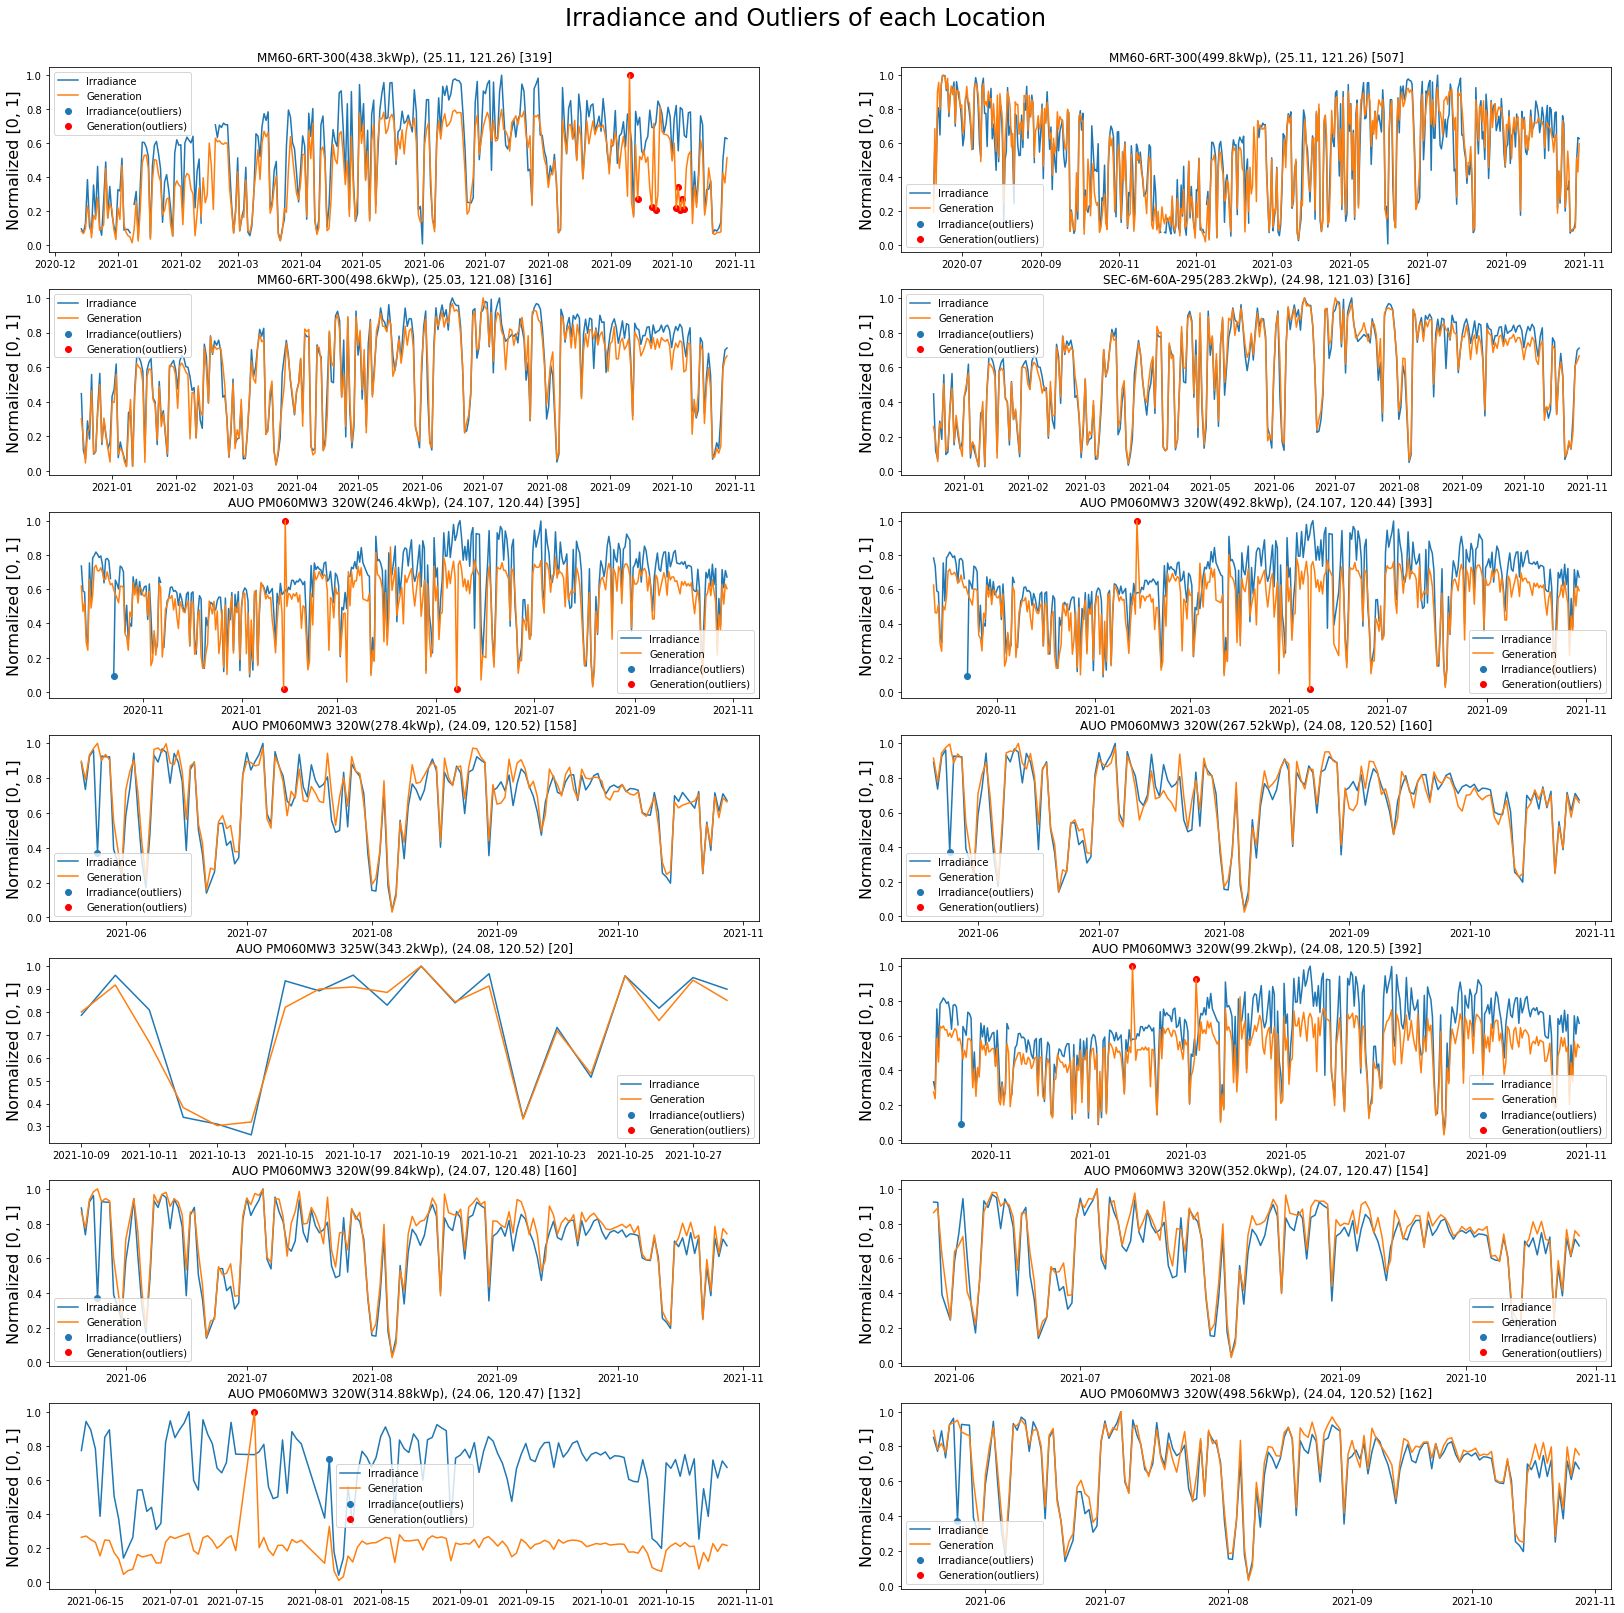

In [92]:
plt.figure(figsize=(28, 28))
plt.suptitle('Irradiance and Outliers of each Location', fontsize=24, y=0.91)
for i, row in train_counts_module_capacity_location.iterrows():
    idf = train[train['Lat'].eq(row['Lat']) & train['Lon'].eq(row['Lon']) & train['Module'].eq(row['Module']) & train['Capacity'].eq(row['Capacity'])]
    outliers1 = idf[idf['Date'].isin(outliers[i]['irradiance'])].index.tolist()
    outliers2 = idf[idf['Date'].isin(outliers[i]['generation'])].index.tolist()
    plt.subplot(math.ceil(len(train_counts_module_capacity_location)/2), 2, i+1)
    plt.title(f"{row['Module']}({row['Capacity']}kWp), ({row['Lat']}, {row['Lon']}) [{len(idf)}]")
    plt.plot(idf['Date'], idf['Irradiance']/idf['Irradiance'].max(), label='Irradiance')
    plt.plot(idf['Date'], idf['Generation']/idf['Generation'].max(), label='Generation')
    plt.scatter(idf[idf.index.isin(outliers1)]['Date'], idf[idf.index.isin(outliers1)]['Irradiance']/idf['Irradiance'].max(), label='Irradiance(outliers)')
    plt.scatter(idf[idf.index.isin(outliers2)]['Date'], idf[idf.index.isin(outliers2)]['Generation']/idf['Generation'].max(), c='r', label='Generation(outliers)')
    plt.ylabel('Normalized [0, 1]', fontsize=16)
    plt.legend() 